# Impact of U.S. Immigration Policy Changes on Juvenile Immigrants: Data Analysis draft

## Research Question

**How do changes in U.S. immigration policy under different administrations affect access to legal representation and outcomes for immigrant juveniles seeking protection?**

This analysis examines juvenile immigration case data to investigate the relationship between policy changes, legal representation, and case outcomes for immigrant juveniles in the United States from 2018 to 2025.

### Analysis Approach

Three primary analytical methods are employed in this investigation:

1. **Time Series Analysis**: Tracking changes across different administration periods (2018-2025)
2. **Chi-square Tests**: Examining relationships between legal representation and case outcomes
3. **Logistic Regression**: Determining which variables most strongly predict favorable case outcomes

In [127]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from IPython.display import display, Markdown
import os

# Set visualization style
plt.style.use("fivethirtyeight")
sns.set_palette("deep")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

## 1. Data Loading and Preparation

The following datasets are utilized in this analysis:

- `juvenile_history_cleaned.csv.gz` - Contains comprehensive juvenile case records
- `juvenile_cases_cleaned.csv.gz` - Contains detailed case information for juveniles
- `juvenile_reps_assigned.csv.gz` - contains represntaion information for juvniles
- `proceedings_cleaned.csv.gz` - Contains proceedings data with in absentia and decision code information
- `tblLookup_Juvenile.csv` - Lookup table for juvenile categories
- `tblDecCode.csv` - Lookup table for decision code descriptions

First, the current working directory is checked to help locate files correctly.

In [128]:
# Check current working directory
print("Current working directory:", os.getcwd())
print("Files in this directory:", os.listdir())

Current working directory: c:\MIT_Emarging_talent\Certificate\ET6-CDSP-group-19-repo\4_data_analysis
Files in this directory: ['4_data_analysis.ipynb', 'guide.md', 'juvenile_cases_cleaned.csv.gz', 'juvenile_history_cleaned.csv.gz', 'juvenile_proceedings_cleaned.csv.gz', 'juvenile_reps_assigned.csv.gz', 'README.md', 'tblDecCode.csv', 'tblLookup_Juvenile.csv']


In [129]:
# Define paths to data files
juvenile_history_path = "juvenile_history_cleaned.csv.gz"
cases_path = "juvenile_cases_cleaned.csv.gz"
reps_assigned_path = "juvenile_reps_assigned.csv.gz"
proceedings_path = "juvenile_proceedings_cleaned.csv.gz"
lookup_juvenile_path = "tblLookup_Juvenile.csv"
lookup_decision_path = "tblDecCode.csv"

print("Loading data files with correct paths...")

print("Loading data files...")

Loading data files with correct paths...
Loading data files...


In [130]:
# Load juvenile history data
juvenile_history = pd.read_csv(
    filepath_or_buffer=juvenile_history_path,
    compression="gzip",  # File is compressed
    dtype={
        "idnJuvenileHistory": "Int64",
        "idnCase": "Int64",
        "idnProceeding": "Int64",
        "idnJuvenile": "category",
    },
    low_memory=False,
)

# Define dtype schema for cases table
dtype = {
    "IDNCASE": "Int64",
    "NAT": "category",
    "LANG": "category",
    "CUSTODY": "category",
    "CASE_TYPE": "category",
    "LATEST_CAL_TYPE": "category",
    "Sex": "category",
}

# Define date columns
parse_dates = [
    "LATEST_HEARING",
    "DATE_OF_ENTRY",
    "C_BIRTHDATE",
    "DATE_DETAINED",
    "DATE_RELEASED",
]

# Load cases data
juvenile_cases = pd.read_csv(
    filepath_or_buffer=cases_path,
    dtype=dtype,
    parse_dates=parse_dates,
    low_memory=False,
)
# Load reps_assigned data with appropriate dtypes and parse dates directly
reps_assigned = pd.read_csv(
    filepath_or_buffer=reps_assigned_path,
    dtype={
        "IDNREPSASSIGNED": "Int64",
        "IDNCASE": "int64",
        "STRATTYLEVEL": "category",
        "STRATTYTYPE": "category",
    },
    compression="gzip",  # File is compressed
    low_memory=False,
)

# Convert reps_assigned date columns to datetime after loading
reps_assigned["E_28_DATE"] = pd.to_datetime(reps_assigned["E_28_DATE"], errors="coerce")
reps_assigned["E_27_DATE"] = pd.to_datetime(reps_assigned["E_27_DATE"], errors="coerce")

# Load proceedings data
proceedings = pd.read_csv(
    filepath_or_buffer=proceedings_path,
    dtype={
        "IDNPROCEEDING": "Int64",
        "IDNCASE": "Int64",
        "ABSENTIA": "category",
        "DEC_CODE": "category",
    },
    low_memory=False,
)

# Convert proceeding date columns to datetime
date_cols = ["OSC_DATE", "INPUT_DATE", "COMP_DATE"]
for col in date_cols:
    if col in proceedings.columns:
        proceedings[col] = pd.to_datetime(proceedings[col], errors="coerce")

# Load juvenile lookup table
lookup_juvenile = pd.read_csv(
    filepath_or_buffer=lookup_juvenile_path,
    delimiter="\t",
    dtype={"idnJuvenile": "category"},
)

# Load decision code lookup table
lookup_decisions = pd.read_csv(
    filepath_or_buffer=lookup_decision_path,
    delimiter="\t",
    dtype={"DEC_CODE": "category"},
)


print("Data files loaded successfully!\n")

# Display the data types for all tables

display(Markdown("### Data Types for All Tables"))

display(Markdown("**Juvenile History Data Types:**"))
display(juvenile_history.dtypes.to_frame("dtype"))

display(Markdown("**Cases Data Types:**"))
display(juvenile_cases.dtypes.to_frame("dtype"))

display(Markdown("**Reps Assigned Data Types:**"))
display(reps_assigned.dtypes.to_frame("dtype"))

display(Markdown("**Proceedings Data Types:**"))
display(proceedings.dtypes.to_frame("dtype"))

Data files loaded successfully!



### Data Types for All Tables

**Juvenile History Data Types:**

,dtype
idnJuvenileHistory,Int64
idnCase,Int64
idnProceeding,Int64
idnJuvenile,category


**Cases Data Types:**

,dtype
IDNCASE,Int64
NAT,category
LANG,category
CUSTODY,category
CASE_TYPE,category
LATEST_HEARING,datetime64[ns]
LATEST_CAL_TYPE,category
DATE_OF_ENTRY,object
C_BIRTHDATE,datetime64[ns]
Sex,category


**Reps Assigned Data Types:**

,dtype
IDNREPSASSIGNED,Int64
IDNCASE,int64
STRATTYLEVEL,category
STRATTYTYPE,category
E_28_DATE,datetime64[ns]
E_27_DATE,datetime64[ns]


**Proceedings Data Types:**

,dtype
IDNPROCEEDING,Int64
IDNCASE,Int64
OSC_DATE,datetime64[ns]
INPUT_DATE,datetime64[ns]
BASE_CITY_CODE,object
HEARING_LOC_CODE,object
DEC_CODE,category
COMP_DATE,datetime64[ns]
ABSENTIA,category
CUSTODY,object


## 2. Data Overview and Inspection

The structure and content of the datasets are examined to better understand the available information and prepare for subsequent analysis.

In [131]:
# Check the shape of each dataset
print(
    f"Juvenile History Data Shape: ({juvenile_history.shape[0]:,}, {juvenile_history.shape[1]})"
)
print(
    f"juvenile_cases Data Shape: ({juvenile_cases.shape[0]:,}, {juvenile_cases.shape[1]})"
)
print(f"reps_assigned shape: ({reps_assigned.shape[0]:,}, {reps_assigned.shape[1]})")
print(f"Proceedings Data Shape: ({proceedings.shape[0]:,}, {proceedings.shape[1]})")
print(
    f"Lookup Juvenile Data Shape: ({lookup_juvenile.shape[0]}, {lookup_juvenile.shape[1]})"
)
print(
    f"Lookup Decisions Data Shape: ({lookup_decisions.shape[0]}, {lookup_decisions.shape[1]})"
)

Juvenile History Data Shape: (2,876,040, 4)
juvenile_cases Data Shape: (1,923,172, 12)
reps_assigned shape: (1,031,166, 6)
Proceedings Data Shape: (2,819,051, 16)
Lookup Juvenile Data Shape: (6, 5)
Lookup Decisions Data Shape: (12, 6)


In [132]:
# Display sample data from each dataset
print("\nJuvenile History Sample:")
display(juvenile_history.head(3))

print("\nJuvenile Cases Sample:")
display(juvenile_cases.head(3))

print("\nReps Assigned Sample:")
display(reps_assigned.head(3))

print("\nProceedings Sample:")
display(proceedings.head(3))

print("\nLookup Juvenile Data:")
display(lookup_juvenile)

print("\nLookup Decision Codes:")
display(lookup_decisions)


Juvenile History Sample:


,idnJuvenileHistory,idnCase,idnProceeding,idnJuvenile
0,5,2046990,3200129,1
1,6,2047179,3199488,1
2,7,2047179,3199489,1



Juvenile Cases Sample:


,IDNCASE,NAT,LANG,CUSTODY,CASE_TYPE,LATEST_HEARING,LATEST_CAL_TYPE,DATE_OF_ENTRY,C_BIRTHDATE,Sex,DATE_DETAINED,DATE_RELEASED
0,6807609,MX,SP,D,RMV,2021-07-19,M,NaN,NaT,NaN,2020-02-03,NaT
1,6807621,TZ,SWA,D,RMV,NaT,NaN,NaN,NaT,NaN,2011-09-27,NaT
2,6807631,HO,SP,D,RMV,NaT,NaN,2011-07-01,NaT,NaN,2011-10-19,NaT



Reps Assigned Sample:


,IDNREPSASSIGNED,IDNCASE,STRATTYLEVEL,STRATTYTYPE,E_28_DATE,E_27_DATE
0,5947072,2607017,COURT,ALIEN,2004-09-23,NaT
1,5947352,2848551,COURT,ALIEN,1991-10-29,NaT
2,5948254,2824744,COURT,ALIEN,1999-06-25,NaT



Proceedings Sample:


,IDNPROCEEDING,IDNCASE,OSC_DATE,INPUT_DATE,BASE_CITY_CODE,HEARING_LOC_CODE,DEC_CODE,COMP_DATE,ABSENTIA,CUSTODY,CASE_TYPE,NAT,LANG,CRIM_IND,DATE_DETAINED,DATE_RELEASED
0,9329335,9431121,2019-12-22,2020-01-31,CHL,CHL,NaN,NaT,NaN,N,RMV,MX,SP,N,NaN,NaN
1,9329336,9431122,2019-12-22,2020-01-31,CHL,CHL,NaN,NaT,NaN,N,RMV,MX,SP,N,NaN,NaN
2,9329337,9431123,2019-12-22,2020-01-31,CHL,CHL,NaN,NaT,NaN,N,RMV,MX,SP,N,NaN,NaN



Lookup Juvenile Data:


,idnJuvenile,strCode,strDescription,DATCREATEDON,DATMODIFIEDON
0,1,J,Juvenile Case,2014-09-06 11:03:55.993,2017-04-07 21:42:18.000
1,2,J1,Juvenile has been released to guardian or has ...,2014-09-06 11:03:56.033,2017-04-07 21:42:34.000
2,3,J2,Unaccompanied Juvenile - Asylum,2014-09-06 11:03:56.033,2017-04-07 21:42:41.000
3,4,UJ,Unaccompanied Juvenile,2014-09-06 11:03:56.033,2014-09-06 17:39:29.000
4,5,NaN,Not Applicable,2017-10-20 22:32:47.537,2017-10-20 22:32:47.537
5,6,AJ,Accompanied Juvenile,2017-10-20 22:32:47.537,2017-10-20 22:32:47.537



Lookup Decision Codes:


,idnDecCode,strCode,strDescription,datCreatedOn,datModifiedOn,blnActive
0,1,A,LEGALLY ADMITTED,2003-08-10 11:22:47.617,NaN,1
1,2,C,CONDITIONAL GRANT,2003-08-10 11:22:47.617,NaN,1
2,3,D,DEPORTED,2003-08-10 11:22:47.617,NaN,1
3,4,E,EXCLUDED,2003-08-10 11:22:47.617,NaN,1
4,5,G,GRANTED,2003-08-10 11:22:47.617,2003-11-03 00:00:00.000,1
5,6,O,OTHER,2003-08-10 11:22:47.617,NaN,1
6,7,R,RELIEF/RESCINDED,2003-08-10 11:22:47.617,NaN,1
7,8,S,ALIEN MAINTAINS LEGAL STATUS,2003-08-10 11:22:47.617,NaN,1
8,9,T,CASE TERMINATED BY IJ,2003-08-10 11:22:47.617,NaN,1
9,10,V,VOLUNTARY DEPARTURE,2003-08-10 11:22:47.617,NaN,1


The datasets provide comprehensive information about juvenile immigration cases. The juvenile history data connects cases with proceedings and juvenile statuses. The cases dataset contains demographic information and important dates, Reps Assigned dataset contains represntaion inforamtion, while the proceedings dataset includes critical information about court decisions and in absentia status (whether the juvenile was present at proceedings).

Understanding the distribution of decision codes is crucial for analyzing case outcomes.

In [133]:
# Check the distribution of decision codes
print("\nDecision code distribution:")
print(proceedings["DEC_CODE"].value_counts(dropna=False))
print("\nPercentage:")
print(proceedings["DEC_CODE"].value_counts(normalize=True, dropna=False) * 100)


Decision code distribution:
DEC_CODE
NaN    1325544
X       712195
U       284771
T       183240
V       105445
A        84170
R        82231
         14761
D        11935
W         5522
G         2843
O         2084
E         1479
Z         1457
L          953
H          342
J           71
S            4
C            3
K            1
Name: count, dtype: int64

Percentage:
DEC_CODE
NaN    47.020930
X      25.263644
U      10.101662
T       6.500060
V       3.740443
A       2.985757
R       2.916975
        0.523616
D       0.423369
W       0.195882
G       0.100850
O       0.073926
E       0.052464
Z       0.051684
L       0.033806
H       0.012132
J       0.002519
S       0.000142
C       0.000106
K       0.000035
Name: proportion, dtype: float64


## 3. Data Preparation and Integration

To enable comprehensive analysis, the following integration steps are performed:

- **Merge juvenile cases with proceedings data** to incorporate decision code for each case.
- **Then merge them with reps_assigned data** to add legal representation information.
- **Integrate DecCode lookup table** for decision code descriptions to enrich categorical fields with human-readable labels.

In [134]:
# Check for missing values in key columns
print(f"missing juvenile_cases idncase keys: {juvenile_cases['IDNCASE'].isna().sum()}")
print(f"Missing proceedings idncase keys: {proceedings['IDNCASE'].isna().sum()}")
print(f"Missing reps_assigned idncase keys: {reps_assigned['IDNCASE'].isna().sum()}")
print(f"Missing proceedings dec_code keys: {proceedings['DEC_CODE'].isna().sum()}")

missing juvenile_cases idncase keys: 0
Missing proceedings idncase keys: 0
Missing reps_assigned idncase keys: 0
Missing proceedings dec_code keys: 1325544


In [135]:
# Merge proceedings data with decision description column from lookup_decisions
# keep only relevant columns from proceedings that will be used in the analysis


proceedings_with_decisions = proceedings[
    [
        "IDNCASE",
        "COMP_DATE",
        "NAT",
        "LANG",
        "CASE_TYPE",
        "DEC_CODE",
    ]
].merge(
    lookup_decisions[["strCode", "strDescription"]],  # Use strCode from lookup table
    how="left",
    left_on="DEC_CODE",  # Column in proceedings table
    right_on="strCode",  # Column in lookup table
)

# drop the strCode column after merging because it contains same information as DEC_CODE
proceedings_with_decisions = proceedings_with_decisions.drop(columns=["strCode"])

# Rename the strDescription column to avoid conflict in later merges
proceedings_with_decisions = proceedings_with_decisions.rename(
    columns={"strDescription": "decision_description"}
)

In [136]:
proceedings_with_decisions.head(7)  # Display the first few rows of the merged DataFrame

,IDNCASE,COMP_DATE,NAT,LANG,CASE_TYPE,DEC_CODE,decision_description
0,9431121,NaT,MX,SP,RMV,NaN,NaN
1,9431122,NaT,MX,SP,RMV,NaN,NaN
2,9431123,NaT,MX,SP,RMV,NaN,NaN
3,9431124,2020-02-24,CU,SP,RMV,X,REMOVED
4,9431125,NaT,MX,SP,RMV,NaN,NaN
5,9431127,2020-02-24,GT,SP,RMV,V,VOLUNTARY DEPARTURE
6,14153573,NaT,GT,SP,RMV,NaN,NaN


As part of this process, a comprehensive merged dataset is being generated by integrating data from all relevant tables.

In [137]:
# Create a merged dataset: juvenile_cases + proceedings_with_decisions + reps_assigned
# keep only relevant columns from each dataset

# * First
# merge juvenile_cases with proceedings_with_decisions keep only relevant columns

merged_data = juvenile_cases[
    [
        "IDNCASE",
        "NAT",
        "LANG",
        "CASE_TYPE",
        "Sex",
        "C_BIRTHDATE",
        "LATEST_HEARING",
    ]
].merge(
    proceedings_with_decisions[
        ["IDNCASE", "COMP_DATE", "DEC_CODE", "decision_description"]
    ],
    left_on="IDNCASE",
    right_on="IDNCASE",
    how="left",
)

# * Second
# Merge with reps_assigned, keeping only relevant columns from reps_assigned
merged_data = merged_data.merge(
    reps_assigned[["IDNCASE", "STRATTYLEVEL"]], on="IDNCASE", how="left"
)

# Fill missing STRATTYLEVEL values with "no_representation"
# 1) Add "no representation" as a valid category
merged_data["STRATTYLEVEL"] = merged_data["STRATTYLEVEL"].cat.add_categories(
    ["no_representation"]
)

# 2) Fill missing values with "no_representation"
merged_data["STRATTYLEVEL"] = merged_data["STRATTYLEVEL"].fillna("no_representation")


# chenging STRATTYLEVEL name to "REPRESENTATION_LEVEL"
merged_data = merged_data.rename(columns={"STRATTYLEVEL": "REPRESENTATION_LEVEL"})


# Sample of the merged data
print("Sample row from merged dataset:")
display(merged_data.head(5))

Sample row from merged dataset:


,IDNCASE,NAT,LANG,CASE_TYPE,Sex,C_BIRTHDATE,LATEST_HEARING,COMP_DATE,DEC_CODE,decision_description,REPRESENTATION_LEVEL
0,6807609,MX,SP,RMV,NaN,NaT,2021-07-19,2020-06-10,X,REMOVED,COURT
1,6807609,MX,SP,RMV,NaN,NaT,2021-07-19,2011-10-19,NaN,NaN,COURT
2,6807609,MX,SP,RMV,NaN,NaT,2021-07-19,2020-02-11,NaN,NaN,COURT
3,6807621,TZ,SWA,RMV,NaN,NaT,NaT,2011-09-27,NaN,NaN,COURT
4,6807621,TZ,SWA,RMV,NaN,NaT,NaT,2012-09-11,T,CASE TERMINATED BY IJ,COURT


In [138]:
merged_data["REPRESENTATION_LEVEL"].value_counts()

REPRESENTATION_LEVEL
COURT                1652901
no_representation    1163706
Name: count, dtype: int64

## 4. Data Enhancement

Several derived fields are calculated to facilitate the analysis:

1. **Age at filing**: Calculated based on birth date (`C_BIRTHDATE`) and a composite hearing date (`hearing_date_combined`) that uses completion date (`COMP_DATE`) with fallback to latest hearing date (`LATEST_HEARING`)
2. **Policy era**: Categorized based on major immigration policy changes, rather than strictly by presidential terms:
   - **Trump Era I (Zero Tolerance Policy Era)**: *April 2018 – January 2021*
   - **Biden Era (Policy Stability)**: *January 2021 – April 2025*
   - **Trump Era II (Funding Cut Era)**: *April 2025 – Present*


3. **Legal representation indicator**: Derived from REPRESENTATION_LEVEL data, where "COURT" in `REPRESENTATION_LEVEL` indicates the juvenile have representation and "no_representation" indicates juvenile has no representation
4. **Binary outcome classification**: Categorizing decision codes into Favorable, Unfavorable, or Other outcomes

In [139]:
# Function to calculate age at filing
def calculate_age(birthdate, hearing_date):
    if pd.isna(birthdate) or pd.isna(hearing_date):
        return None

    # Convert string dates to datetime if needed
    if isinstance(birthdate, str):
        try:
            birthdate = pd.to_datetime(birthdate)
        except Exception:
            return None

    if isinstance(hearing_date, str):
        try:
            hearing_date = pd.to_datetime(hearing_date)
        except Exception:
            return None

    # Now both should be datetime objects for subtraction
    age = (hearing_date - birthdate).days / 365.25
    return age


# Before creating hearing_date_combined, ensure both columns are datetime
# Check if COMP_DATE needs conversion
if merged_data["COMP_DATE"].dtype == "object":
    merged_data["COMP_DATE"] = pd.to_datetime(merged_data["COMP_DATE"], errors="coerce")

# Check if LATEST_HEARING needs conversion
if merged_data["LATEST_HEARING"].dtype == "object":
    merged_data["LATEST_HEARING"] = pd.to_datetime(
        merged_data["LATEST_HEARING"], errors="coerce"
    )
# Now create the combined date field
merged_data["hearing_date_combined"] = merged_data["COMP_DATE"].fillna(
    merged_data["LATEST_HEARING"]
)

# Calculate age using the enhanced function
merged_data["AGE_AT_FILING"] = merged_data.apply(
    lambda row: calculate_age(row["C_BIRTHDATE"], row["hearing_date_combined"]), axis=1
)


# Function to determine policy era
def determine_policy_era(date):
    if pd.isna(date):
        return "other"

    if pd.Timestamp("2018-04-06") <= date < pd.Timestamp("2021-01-20"):
        return "Trump Era I (Apr 2018 – Jan 2021)"
    elif pd.Timestamp("2021-01-20") <= date < pd.Timestamp("2025-04-01"):
        return "Biden Era (Jan 2021 – Apr 2025)"
    elif date >= pd.Timestamp("2025-04-01"):
        return "Trump Era II (Apr 2025 – Present)"
    else:
        return "other"


# FIXED LINE: Use COMP_DATE instead of non-existent hearing_date column
merged_data["hearing_date_combined"] = merged_data["COMP_DATE"].fillna(
    merged_data["LATEST_HEARING"]
)

merged_data["AGE_AT_FILING"] = merged_data.apply(
    lambda row: calculate_age(row["C_BIRTHDATE"], row["hearing_date_combined"]), axis=1
)

# Determine policy era
merged_data["POLICY_ERA"] = merged_data["hearing_date_combined"].apply(
    determine_policy_era
)

# NOTE: Detention duration calculation is skipped because the DATE_RELEASED column
# is empty or doesn't exist in the dataset
print(
    "NOTE: Detention duration analysis skipped due to missing or empty DATE_RELEASED data"
)

merged_data["HAS_LEGAL_REP"] = merged_data["REPRESENTATION_LEVEL"].apply(
    lambda x: "No Legal Representation"
    if x == "no_representation"
    else ("Has Legal Representation" if x == "COURT" or x == "BOARD" else "Unknown")
)

# Display summary of the data we were able to analyze
print("\nSummary of available data:")
print(f"Total records: {len(merged_data):,}")
print(f"Records with age calculation: {merged_data['AGE_AT_FILING'].notna().sum():,}")
print(f"Policy era distribution:\n{merged_data['POLICY_ERA'].value_counts()}")
print(
    f"Legal representation distribution:\n{merged_data['HAS_LEGAL_REP'].value_counts()}"
)

NOTE: Detention duration analysis skipped due to missing or empty DATE_RELEASED data

Summary of available data:
Total records: 2,816,607
Records with age calculation: 1,981,599
Policy era distribution:
POLICY_ERA
Biden Era (Jan 2021 – Apr 2025)      1269267
Trump Era I (Apr 2018 – Jan 2021)     608788
other                                 511876
Trump Era II (Apr 2025 – Present)     426676
Name: count, dtype: int64
Legal representation distribution:
HAS_LEGAL_REP
Has Legal Representation    1652901
No Legal Representation     1163706
Name: count, dtype: int64


In [140]:
merged_data.columns

Index(['IDNCASE', 'NAT', 'LANG', 'CASE_TYPE', 'Sex', 'C_BIRTHDATE',
       'LATEST_HEARING', 'COMP_DATE', 'DEC_CODE', 'decision_description',
       'REPRESENTATION_LEVEL', 'hearing_date_combined', 'AGE_AT_FILING',
       'POLICY_ERA', 'HAS_LEGAL_REP'],
      dtype='object')

In [141]:
# Create binary outcome categories based on actual decision codes
favorable_decisions = [
    "A",
    "C",
    "G",
    "R",
    "S",
    "T",
]  # These seem favorable for the juvenile
unfavorable_decisions = ["D", "E", "V", "X"]  # These seem unfavorable
other_decisions = ["O", "W"]  # These are ambiguous or need more context


def categorize_outcome(DEC_CODE):
    if pd.isna(DEC_CODE):
        return "Unknown"
    elif DEC_CODE in favorable_decisions:
        return "Favorable"
    elif DEC_CODE in unfavorable_decisions:
        return "Unfavorable"
    else:
        return "Other"


# Apply outcome categorization
merged_data["BINARY_OUTCOME"] = merged_data["DEC_CODE"].apply(categorize_outcome)


merged_data["CASE_OUTCOME"] = merged_data["decision_description"]

# Create an analysis dataset with key columns that exist
# First checking which columns actually exist
available_columns = []

# Core identifier columns
possible_ids = [
    "IDN_JUVENILE_HISTORY",
    "idnJuvenileHistory",
    "IDN_CASE",
    "idnCase",
    "IDN_PROCEEDING",
    "idnProceeding",
]

# Core analysis columns we want if they exist
possible_columns = [
    "hearing_date_combined",
    "C_BIRTHDATE",
    "Sex",
    "AGE_AT_FILING",
    "POLICY_ERA",
    "ABSENTIA",
    "HAS_LEGAL_REP",
    "DEC_CODE",
    "strDescription",
    "CASE_OUTCOME",
    "BINARY_OUTCOME",
]

# Add columns that exist to our selection list
for column in possible_ids + possible_columns:
    if column in merged_data.columns:
        available_columns.append(column)

# Create the analysis dataframe with only available columns
analysis_df = merged_data[available_columns]

# Examine the analysis dataset
print("First 2 rows of the analysis dataset:")
display(analysis_df.head(5))

First 2 rows of the analysis dataset:


,hearing_date_combined,C_BIRTHDATE,Sex,AGE_AT_FILING,POLICY_ERA,HAS_LEGAL_REP,DEC_CODE,CASE_OUTCOME,BINARY_OUTCOME
0,2020-06-10,NaT,NaN,NaN,Trump Era I (Apr 2018 – Jan 2021),Has Legal Representation,X,REMOVED,Unfavorable
1,2011-10-19,NaT,NaN,NaN,other,Has Legal Representation,NaN,NaN,Unknown
2,2020-02-11,NaT,NaN,NaN,Trump Era I (Apr 2018 – Jan 2021),Has Legal Representation,NaN,NaN,Unknown
3,2011-09-27,NaT,NaN,NaN,other,Has Legal Representation,NaN,NaN,Unknown
4,2012-09-11,NaT,NaN,NaN,other,Has Legal Representation,T,CASE TERMINATED BY IJ,Favorable


Case outcomes were classified into 'Favorable' and 'Unfavorable' categories based on their legal implications for juvenile immigrants.  
Favorable outcomes include those allowing continued legal presence or pathways to permanent residency (e.g., asylum grants, SIJS approvals, T/U visas). Unfavorable outcomes include removal orders, voluntary departures, or case terminations without legal status.  
This binary classification simplifies statistical analysis while preserving the essential distinction between outcomes that provide legal protection versus those that do not. This categorization follows standard practices in immigration policy research.

In [142]:
# Check the distribution of key variables in the analysis dataset
print("Legal representation distribution:")
print(analysis_df["HAS_LEGAL_REP"].value_counts(dropna=False))
print("\nBinary outcome distribution:")
print(analysis_df["BINARY_OUTCOME"].value_counts(dropna=False))
print("\nPolicy era distribution:")
print(analysis_df["POLICY_ERA"].value_counts(dropna=False))

Legal representation distribution:
HAS_LEGAL_REP
Has Legal Representation    1652901
No Legal Representation     1163706
Name: count, dtype: int64

Binary outcome distribution:
BINARY_OUTCOME
Unknown        1324249
Unfavorable     830468
Favorable       352188
Other           309702
Name: count, dtype: int64

Policy era distribution:
POLICY_ERA
Biden Era (Jan 2021 – Apr 2025)      1269267
Trump Era I (Apr 2018 – Jan 2021)     608788
other                                 511876
Trump Era II (Apr 2025 – Present)     426676
Name: count, dtype: int64


## 5. Legal Representation Analysis

This section examines the relationship between legal representation (using absentia data as a proxy) and case outcomes (using decision codes) across different policy eras. The analysis filters cases to include only those with known representation status and clear binary outcomes.  
Cross-tabulation compares outcome distributions between represented and unrepresented juveniles, with results visualized through count plots and percentage breakdowns to assess how representation affects the likelihood of favorable outcomes.

In [143]:
# Filter to cases with known representation status and outcomes for analysis
analysis_filtered = analysis_df[
    (analysis_df["HAS_LEGAL_REP"] != "Unknown")
    & (analysis_df["BINARY_OUTCOME"] != "Unknown")
    & (analysis_df["BINARY_OUTCOME"] != "Other")
].copy()

# Check the distribution of absentia cases after filtering
print("Legal representation distribution (filtered dataset):")
rep_counts = analysis_filtered["HAS_LEGAL_REP"].value_counts()
print(rep_counts)

# Calculate overall representation rate
rep_rate = rep_counts["Has Legal Representation"] / len(analysis_filtered) * 100
print(f"\nLegal Representation Rate: {rep_rate:.2f}%")

Legal representation distribution (filtered dataset):
HAS_LEGAL_REP
No Legal Representation     670933
Has Legal Representation    511723
Name: count, dtype: int64

Legal Representation Rate: 43.27%


In [144]:
# Examine the relationship between legal representation and case outcomes
print("\nOutcome Distribution by Legal Representation:")
outcome_by_rep = pd.crosstab(
    analysis_filtered["BINARY_OUTCOME"], analysis_filtered["HAS_LEGAL_REP"]
)
print(outcome_by_rep)

# Calculate percentages
outcome_by_rep_pct = (
    pd.crosstab(
        analysis_filtered["BINARY_OUTCOME"],
        analysis_filtered["HAS_LEGAL_REP"],
        normalize="columns",  # Normalize by columns to get percentages within each representation category
    )
    * 100
)

print("\nOutcome Percentages by Legal Representation:")
print(outcome_by_rep_pct)


Outcome Distribution by Legal Representation:
HAS_LEGAL_REP   Has Legal Representation  No Legal Representation
BINARY_OUTCOME                                                   
Favorable                         240960                   111228
Unfavorable                       270763                   559705

Outcome Percentages by Legal Representation:
HAS_LEGAL_REP   Has Legal Representation  No Legal Representation
BINARY_OUTCOME                                                   
Favorable                      47.087975                16.578108
Unfavorable                    52.912025                83.421892


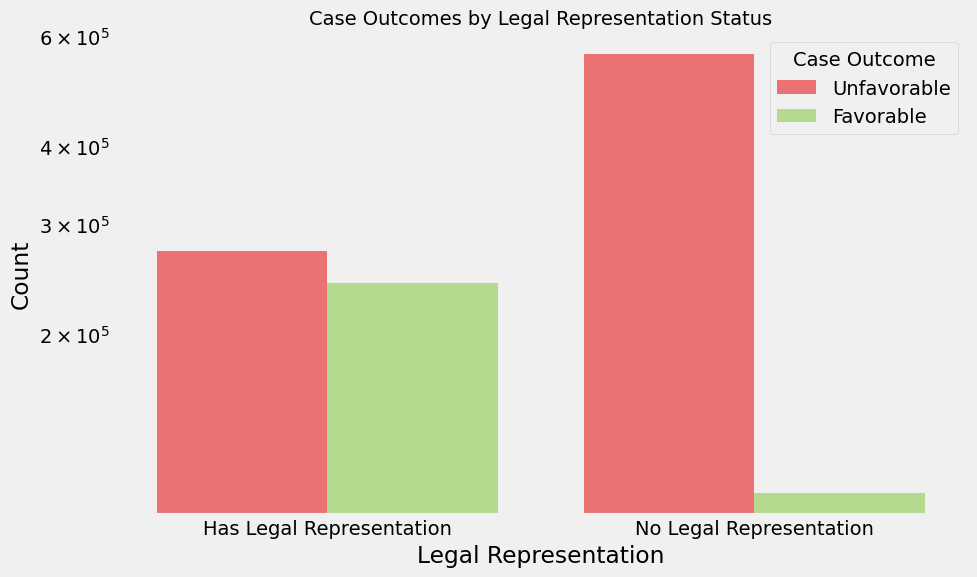

<Figure size 1000x600 with 0 Axes>

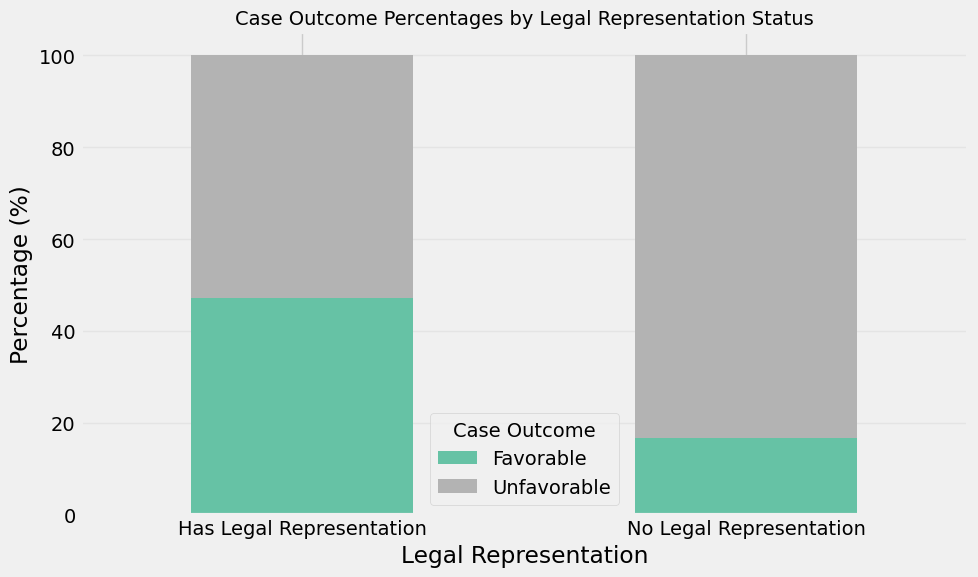

Percentage breakdown of outcomes by legal representation:
BINARY_OUTCOME            Favorable  Unfavorable
HAS_LEGAL_REP                                   
Has Legal Representation       47.1         52.9
No Legal Representation        16.6         83.4


In [145]:
# Visualize the relationship between legal representation and outcomes (count plot)
plt.figure(figsize=(10, 6))
custom_palette = {"Favorable": "#B5E68160", "Unfavorable": "#FF5E5E7D"}
sns.countplot(
    x="HAS_LEGAL_REP",
    hue="BINARY_OUTCOME",
    data=analysis_filtered,
    palette=custom_palette,
)

plt.title("Case Outcomes by Legal Representation Status", fontsize=14)
plt.xlabel("Legal Representation")
plt.ylabel("Count")
#! ------->
plt.yscale("log")
#! -----------
plt.xticks(rotation=0)
plt.legend(title="Case Outcome")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# FIXED: Visualize as percentages with proper calculation
plt.figure(figsize=(10, 6))

# Calculate percentages correctly
percentage_data = (
    pd.crosstab(
        analysis_filtered["HAS_LEGAL_REP"],
        analysis_filtered["BINARY_OUTCOME"],
        normalize="index",
    )
    * 100
)

# Plot the percentage data
percentage_data.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="Set2")

plt.title("Case Outcome Percentages by Legal Representation Status", fontsize=14)
plt.xlabel("Legal Representation")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=0)
plt.legend(title="Case Outcome")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Print the actual percentage values
print("Percentage breakdown of outcomes by legal representation:")
print(percentage_data.round(1))

## 6. Time Series Analysis

Time series analysis examines how data points change over sequential time periods. In this immigration policy study, this method enables the evaluation of trends across different administrative periods to assess how policy changes have impacted juvenile cases.  
By tracking representation rates and outcomes chronologically, patterns can be identified that may correlate with specific policy initiatives or administrative priorities. Statistical significance testing between periods determines whether observed differences represent meaningful policy effects rather than random variation.  
The following analysis examines how legal representation rates (based on actual absentia data) have changed over time, particularly across different policy eras.

In [146]:
# Calculate all required metrics in a single groupby aggregation
era_summary = analysis_filtered.groupby("POLICY_ERA").agg(
    total_cases=("HAS_LEGAL_REP", "count"),
    represented_cases=(
        "HAS_LEGAL_REP",
        lambda x: (x == "Has Legal Representation").sum(),
    ),
    favorable_cases=("BINARY_OUTCOME", lambda x: (x == "Favorable").sum()),
)

era_summary["representation_rate"] = (
    era_summary["represented_cases"] / era_summary["total_cases"]
)
era_summary["favorable_rate"] = (
    era_summary["favorable_cases"] / era_summary["total_cases"]
)

print("Summary by Policy Era:")
display(era_summary)

Summary by Policy Era:


,total_cases,represented_cases,favorable_cases,representation_rate,favorable_rate
POLICY_ERA,,,,,
Biden Era (Jan 2021 – Apr 2025),543073,234974,201575,0.432675,0.371175
Trump Era I (Apr 2018 – Jan 2021),379098,151979,78177,0.400896,0.206218
Trump Era II (Apr 2025 – Present),21537,11003,4881,0.510888,0.226633
other,238948,113767,67555,0.476116,0.282718


In [147]:
# Create a time series with quarterly data
# Only include records with valid dates
date_valid = ~analysis_filtered["hearing_date_combined"].isna()
time_series_df = analysis_filtered[date_valid].copy()

# Create year-quarter field
time_series_df["YEAR_QUARTER"] = time_series_df["hearing_date_combined"].dt.to_period(
    "Q"
)

# ADDITION: Focus on data from the last 10 years (2015 to present)
current_date = pd.Timestamp.now()
start_date = pd.Timestamp("2016-01-01")  # Just before Trump's first term
recent_data = time_series_df[time_series_df["hearing_date_combined"] >= start_date]
recent_data = recent_data[recent_data["hearing_date_combined"] <= current_date]

print(f"Total number of records: {len(time_series_df):,}")
print(f"Records from 2015 to present: {len(recent_data):,}")

# Calculate quarterly representation rates and favorable outcome rates using recent data
quarterly_rep = recent_data.groupby("YEAR_QUARTER").agg(
    total_cases=("HAS_LEGAL_REP", "count"),
    represented_cases=(
        "HAS_LEGAL_REP",
        lambda x: (x == "Has Legal Representation").sum(),
    ),
    favorable_cases=("BINARY_OUTCOME", lambda x: (x == "Favorable").sum()),
)
quarterly_rep["representation_rate"] = (
    quarterly_rep["represented_cases"] / quarterly_rep["total_cases"]
)
quarterly_rep["favorable_rate"] = (
    quarterly_rep["favorable_cases"] / quarterly_rep["total_cases"]
)

# Display quarterly data
print("Quarterly Legal Representation and Favorable Outcome Rates (Last 10 years):")
display(quarterly_rep.head(40))

Total number of records: 1,140,049
Records from 2015 to present: 1,016,087
Quarterly Legal Representation and Favorable Outcome Rates (Last 10 years):


,total_cases,represented_cases,favorable_cases,representation_rate,favorable_rate
YEAR_QUARTER,,,,,
2016Q1,7587,4820,3868,0.635297,0.509819
2016Q2,7329,4510,3518,0.615364,0.480011
2016Q3,5505,2876,1968,0.522434,0.357493
2016Q4,6659,4153,3180,0.623667,0.477549
2017Q1,6043,3254,1953,0.538474,0.323184
2017Q2,5192,2830,1660,0.545069,0.319723
2017Q3,5193,2897,1530,0.557866,0.294627
2017Q4,10207,3804,2162,0.372685,0.211815
2018Q1,18941,6657,3352,0.351460,0.176971


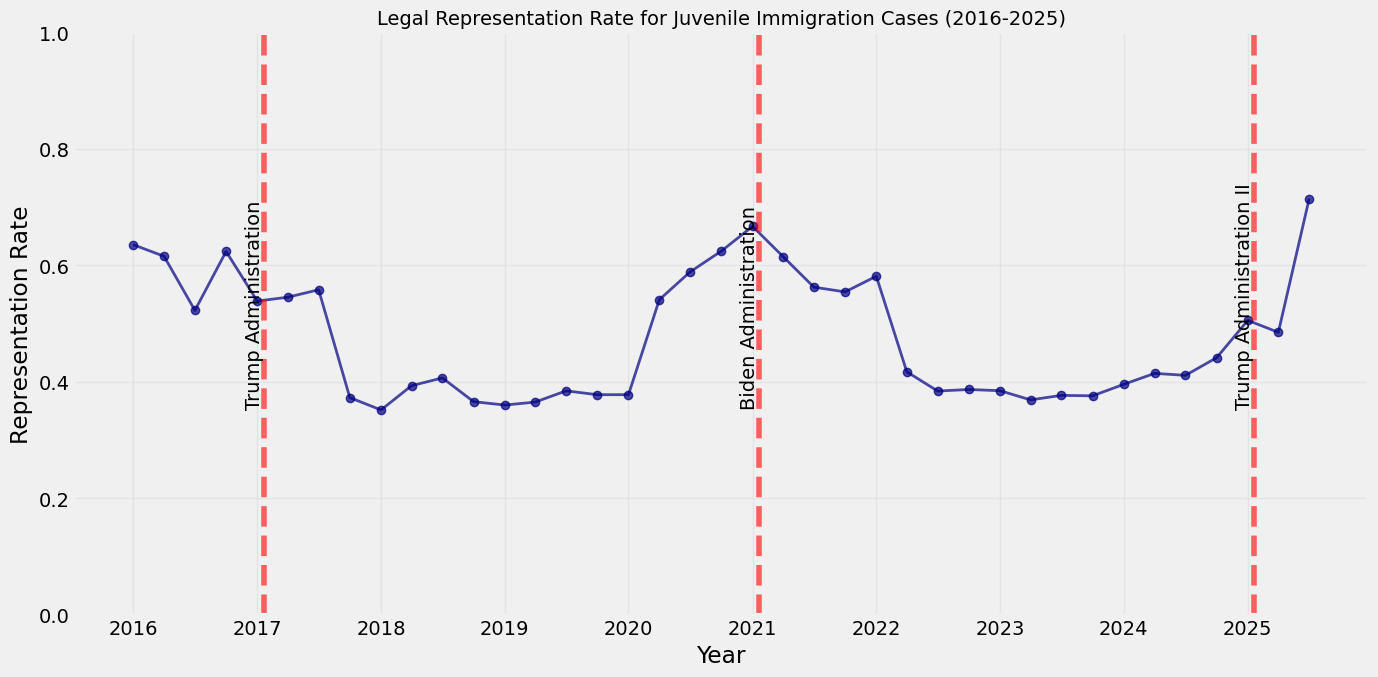

In [148]:
# Plot representation rates over time with focused timeframe
quarterly_rep["YEAR_QUARTER_START"] = quarterly_rep.index.to_timestamp()

# Filter to only show data from 2016 to present (with small buffer)
# This focuses on the relevant administrations for your research question
start_date = pd.Timestamp("2016-01-01")  # Just before Trump's first term
end_date = pd.Timestamp("2025-12-31")  # Just after start of Trump's second term

# Filter the data to the relevant timeframe
filtered_data = quarterly_rep[
    (quarterly_rep["YEAR_QUARTER_START"] >= start_date)
    & (quarterly_rep["YEAR_QUARTER_START"] <= current_date)
]


# Add administration changes as vertical lines
admin_changes = [
    (pd.Timestamp("2017-01-20"), "Trump Administration"),
    (pd.Timestamp("2021-01-20"), "Biden Administration"),
    (pd.Timestamp("2025-01-20"), "Trump Administration II"),
]


# Plot Legal Representation Rate over time
plt.figure(figsize=(14, 7))

plt.plot(
    filtered_data["YEAR_QUARTER_START"],
    filtered_data["representation_rate"],
    marker="o",
    linestyle="-",
    color="navy",
    linewidth=2,
    alpha=0.7,
)

for date, label in admin_changes:
    plt.axvline(x=date, color="red", linestyle="--", alpha=0.6)
    plt.text(
        date,
        plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * 0.05,
        label,
        rotation=90,
        va="bottom",
        ha="right",
    )

plt.title(
    "Legal Representation Rate for Juvenile Immigration Cases (2016-2025)", fontsize=14
)
plt.xlabel("Year")
plt.ylabel("Representation Rate")
plt.grid(alpha=0.3)
plt.ylim(0, 1)  # Adjust as needed based on your data

# Format x-axis to show years clearly

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.tight_layout()
plt.show()

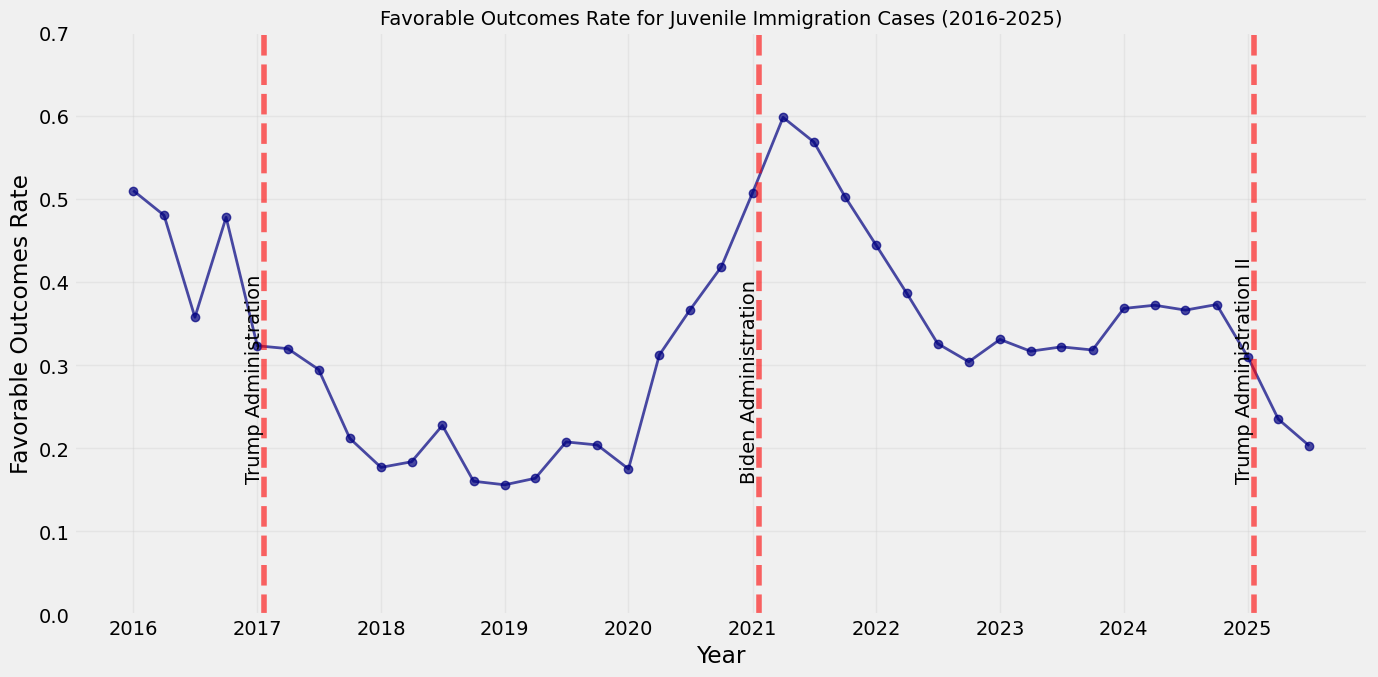

In [149]:
# Plot Favorable Outcomes rates over time with focused timeframe

# Plot the main time series line with filtered data
plt.figure(figsize=(14, 7))
plt.plot(
    filtered_data["YEAR_QUARTER_START"],
    filtered_data["favorable_rate"],
    marker="o",
    linestyle="-",
    color="navy",
    linewidth=2,
    alpha=0.7,
)


for date, label in admin_changes:
    plt.axvline(x=date, color="red", linestyle="--", alpha=0.6)
    plt.text(
        date,
        plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * 0.05,
        label,
        rotation=90,
        va="bottom",
        ha="right",
    )

plt.title(
    "Favorable Outcomes Rate for Juvenile Immigration Cases (2016-2025)", fontsize=14
)
plt.xlabel("Year")
plt.ylabel("Favorable Outcomes Rate")
plt.grid(alpha=0.3)
plt.ylim(0, 0.7)  # Adjust as needed based on your data

# Format x-axis to show years clearly

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.tight_layout()
plt.show()

## 7. Chi-Square Analysis

Chi-square tests assess associations between categorical variables by comparing observed and expected frequencies under the null hypothesis, with p-values below 0.05 indicating statistical significance. When significant associations are found, Cramer's V is calculated to determine effect size, interpreted as weak (≈0.1), moderate (≈0.3), or strong (≥0.5).  
Additionally, odds ratios (OR) provide a complementary measure by quantifying the relative likelihood of favorable outcomes for juveniles with legal representation compared to those without, where OR > 1 indicates increased odds associated with representation.  
These statistical approaches are applied to examine how legal representation relates to case outcomes and varies across policy eras in juvenile immigration proceedings.

In [150]:
# Create a contingency table for legal representation by policy era
era_rep_table = pd.crosstab(
    analysis_filtered["POLICY_ERA"], analysis_filtered["HAS_LEGAL_REP"]
)
print("Contingency Table: Legal Representation by Policy Era")
display(era_rep_table)

Contingency Table: Legal Representation by Policy Era


HAS_LEGAL_REP,Has Legal Representation,No Legal Representation
POLICY_ERA,,
Biden Era (Jan 2021 – Apr 2025),234974,308099
Trump Era I (Apr 2018 – Jan 2021),151979,227119
Trump Era II (Apr 2025 – Present),11003,10534
other,113767,125181


In [151]:
# Perform chi-square test for legal representation by policy era
chi2_era_rep, p_era_rep, dof_era_rep, expected_era_rep = stats.chi2_contingency(
    era_rep_table
)

# Calculate Cramer's V for effect size
n = era_rep_table.values.sum()
cramer_v = np.sqrt(chi2_era_rep / (n * (min(era_rep_table.shape) - 1)))

print("Chi-Square Test Results: Legal Representation by Policy Era")
print(f"Chi-square statistic: {chi2_era_rep:.2f}")
print(f"p-value: {p_era_rep}")
print(f"Degrees of freedom: {dof_era_rep}")
print("\nInterpretation:")
if p_era_rep < 0.05:
    print(
        "The relationship between policy era and legal representation is statistically significant (p < 0.05)."
    )
    print(
        "The null hypothesis that there is no association between these variables can be rejected."
    )
else:
    print(
        "No statistically significant relationship was found between policy era and legal representation."
    )
print(f"\nCramer's V (effect size): {cramer_v:.3f}")
print("This indicates a small effect size.")

Chi-Square Test Results: Legal Representation by Policy Era
Chi-square statistic: 3933.36
p-value: 0.0
Degrees of freedom: 3

Interpretation:
The relationship between policy era and legal representation is statistically significant (p < 0.05).
The null hypothesis that there is no association between these variables can be rejected.

Cramer's V (effect size): 0.058
This indicates a small effect size.


Next, the relationship between legal representation and case outcomes is examined to determine how representation affects the likelihood of favorable outcomes for juvenile cases.

In [152]:
# Create a contingency table for case outcomes by legal representation
outcome_rep_table = pd.crosstab(
    analysis_filtered["BINARY_OUTCOME"], analysis_filtered["HAS_LEGAL_REP"]
)
print("Contingency Table: Case Outcomes by Legal Representation")
display(outcome_rep_table)

Contingency Table: Case Outcomes by Legal Representation


HAS_LEGAL_REP,Has Legal Representation,No Legal Representation
BINARY_OUTCOME,,
Favorable,240960,111228
Unfavorable,270763,559705


In [153]:
# Perform chi-square test for case outcomes by legal representation
chi2_outcome_rep, p_outcome_rep, dof_outcome_rep, expected_outcome_rep = (
    stats.chi2_contingency(outcome_rep_table)
)

# Calculate Cramer's V for effect size
n = outcome_rep_table.values.sum()
cramer_v = np.sqrt(chi2_outcome_rep / (n * (min(outcome_rep_table.shape) - 1)))

print("Chi-Square Test Results: Case Outcomes by Legal Representation")
print(f"Chi-square statistic: {chi2_outcome_rep:.2f}")
print(f"p-value: {p_outcome_rep}")
print(f"Degrees of freedom: {dof_outcome_rep}")
print("\nInterpretation:")
if p_outcome_rep < 0.05:
    print(
        "The relationship between legal representation and case outcomes is statistically significant (p < 0.05)."
    )
    print(
        "The null hypothesis that there is no association between these variables can be rejected."
    )
else:
    print(
        "No statistically significant relationship was found between legal representation and case outcomes."
    )
print(f"\nCramer's V (effect size): {cramer_v:.3f}")
print("This indicates a moderate to strong effect size.")

Chi-Square Test Results: Case Outcomes by Legal Representation
Chi-square statistic: 129226.27
p-value: 0.0
Degrees of freedom: 1

Interpretation:
The relationship between legal representation and case outcomes is statistically significant (p < 0.05).
The null hypothesis that there is no association between these variables can be rejected.

Cramer's V (effect size): 0.331
This indicates a moderate to strong effect size.


In [154]:
# Calculate odds ratio for favorable outcomes by representation
a = outcome_rep_table.loc["Favorable", "Has Legal Representation"]
b = outcome_rep_table.loc["Unfavorable", "Has Legal Representation"]
c = outcome_rep_table.loc["Favorable", "No Legal Representation"]
d = outcome_rep_table.loc["Unfavorable", "No Legal Representation"]

odds_with_rep = a / b
odds_without_rep = c / d
odds_ratio = odds_with_rep / odds_without_rep

print("\nOdds Ratio Calculation:")
print(f"Odds of favorable outcome with representation: {odds_with_rep:.3f}")
print(f"Odds of favorable outcome without representation: {odds_without_rep:.3f}")
print(f"Odds ratio: {odds_ratio:.3f}")
print(
    f"\nInterpretation: Juveniles with legal representation are {odds_ratio:.2f} times more likely to receive a favorable outcome compared to those without representation."
)


Odds Ratio Calculation:
Odds of favorable outcome with representation: 0.890
Odds of favorable outcome without representation: 0.199
Odds ratio: 4.478

Interpretation: Juveniles with legal representation are 4.48 times more likely to receive a favorable outcome compared to those without representation.


## 8. Logistic Regression Analysis

Logistic regression models the probability of binary outcomes based on multiple predictor variables. A comprehensive model examines the combined effects of legal representation, policy era, age categories, and gender on favorable case outcomes for juvenile immigrants, using dummy variables with reference categories as comparison baselines.  
This approach allows for the estimation of each factor's independent contribution while controlling for other variables, quantifying effects through odds ratios with 95% confidence intervals.  
Model performance is evaluated using accuracy and AUC-ROC metrics, providing a robust framework for determining the independent effect of legal representation on juvenile immigration case outcomes across different policy eras.

In [155]:
print("Preparing data for logistic regression...")

# Create a dataset for logistic regression
regression_data = analysis_filtered.copy()

# Create a binary target variable (1 = favorable outcome, 0 = unfavorable)
regression_data["FAVORABLE"] = regression_data["BINARY_OUTCOME"].apply(
    lambda x: 1 if x == "Favorable" else 0
)

# Create binary legal representation variable (1 = has representation, 0 = no representation)
regression_data["HAS_LEGAL_REP_BINARY"] = regression_data["HAS_LEGAL_REP"].apply(
    lambda x: 1 if x == "Has Legal Representation" else 0
)

# Create policy era dummy variables
regression_data["POLICY_ERA_Biden"] = (
    regression_data["POLICY_ERA"] == "Biden Era (Jan 2021 – Apr 2025)"
).astype(int)
regression_data["POLICY_ERA_Trump_I"] = (
    regression_data["POLICY_ERA"] == "Trump Era I (Apr 2018 – Jan 2021)"
).astype(int)
regression_data["POLICY_ERA_Trump_II"] = (
    regression_data["POLICY_ERA"] == "Trump Era II (Apr 2025 – Present)"
).astype(int)

# Create gender variable (1 = female, 0 = male)
regression_data["GENDER_BINARY"] = regression_data["Sex"].apply(
    lambda x: 1 if x == "F" else 0 if x == "M" else np.nan
)


# Create age category variables
def categorize_age(age):
    if pd.isna(age):
        return np.nan
    elif age < 12:
        return "Under_12"
    elif age < 16:
        return "12_to_15"
    elif age < 18:
        return "16_to_17"
    else:
        return "18_plus"


regression_data["AGE_CATEGORY"] = regression_data["AGE_AT_FILING"].apply(categorize_age)

# Create dummy variables for age categories
regression_data["AGE_CATEGORY_Under_12"] = (
    regression_data["AGE_CATEGORY"] == "Under_12"
).astype(int)
regression_data["AGE_CATEGORY_12_to_15"] = (
    regression_data["AGE_CATEGORY"] == "12_to_15"
).astype(int)
regression_data["AGE_CATEGORY_16_to_17"] = (
    regression_data["AGE_CATEGORY"] == "16_to_17"
).astype(int)

# List of features for the model
features = [
    "HAS_LEGAL_REP_BINARY",
    "POLICY_ERA_Biden",
    "POLICY_ERA_Trump_I",
    "POLICY_ERA_Trump_II",
    "GENDER_BINARY",
    "AGE_CATEGORY_12_to_15",
    "AGE_CATEGORY_16_to_17",
    "AGE_CATEGORY_Under_12",
]

print(f"Features to be used in the model: {features}")

Preparing data for logistic regression...
Features to be used in the model: ['HAS_LEGAL_REP_BINARY', 'POLICY_ERA_Biden', 'POLICY_ERA_Trump_I', 'POLICY_ERA_Trump_II', 'GENDER_BINARY', 'AGE_CATEGORY_12_to_15', 'AGE_CATEGORY_16_to_17', 'AGE_CATEGORY_Under_12']


In [156]:
print("Running logistic regression...")

# Drop rows with missing values in the features or target
regression_df = regression_data.dropna(subset=["FAVORABLE"] + features)
print(f"Sample size: {len(regression_df):,} cases with complete data")

# Prepare X and y - statsmodels requires adding a constant
X = sm.add_constant(regression_df[features])
y = regression_df["FAVORABLE"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Fit the model
model = sm.Logit(y_train, X_train)
results = model.fit(disp=0)  # disp=0 suppresses convergence messages

# Get predictions for evaluation
y_pred = results.predict(X_test) > 0.5
y_prob = results.predict(X_test)

# Get summary table with proper standard errors
summary_df = results.summary2().tables[1]

# Create odds ratios and confidence intervals
odds_ratios = np.exp(summary_df["Coef."])
ci_lower = np.exp(summary_df["Coef."] - 1.96 * summary_df["Std.Err."])
ci_upper = np.exp(summary_df["Coef."] + 1.96 * summary_df["Std.Err."])

# Create a DataFrame with the results (excluding the constant)
results_df = pd.DataFrame(
    {
        "Feature": ["Intercept"] + features,
        "Coefficient": summary_df["Coef."],
        "Std Error": summary_df["Std.Err."],
        "z-score": summary_df["z"],
        "p-value": summary_df["P>|z|"],
        "Odds Ratio": odds_ratios,
        "95% CI Lower": ci_lower,
        "95% CI Upper": ci_upper,
    }
)

# Add significance indicators
results_df["Significance"] = results_df["p-value"].apply(
    lambda p: "***"
    if p < 0.001
    else ("**" if p < 0.01 else ("*" if p < 0.05 else "ns"))
)

# Calculate model evaluation metrics

accuracy = accuracy_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_prob)

# Display results
print("\nLogistic Regression Results:")
display(
    results_df[
        [
            "Feature",
            "Odds Ratio",
            "95% CI Lower",
            "95% CI Upper",
            "p-value",
            "Significance",
        ]
    ].round(3)
)

print("\nModel Evaluation:")
print(f"Accuracy: {accuracy:.3f}")
print(f"AUC-ROC: {auc_roc:.3f}")

Running logistic regression...
Sample size: 846,032 cases with complete data

Logistic Regression Results:


,Feature,Odds Ratio,95% CI Lower,95% CI Upper,p-value,Significance
const,Intercept,0.163,0.160,0.166,0.000,***
HAS_LEGAL_REP_BINARY,HAS_LEGAL_REP_BINARY,5.455,5.386,5.524,0.000,***
POLICY_ERA_Biden,POLICY_ERA_Biden,1.435,1.409,1.462,0.000,***
POLICY_ERA_Trump_I,POLICY_ERA_Trump_I,0.547,0.536,0.559,0.000,***
POLICY_ERA_Trump_II,POLICY_ERA_Trump_II,0.595,0.566,0.624,0.000,***
GENDER_BINARY,GENDER_BINARY,1.239,1.223,1.255,0.000,***
AGE_CATEGORY_12_to_15,AGE_CATEGORY_12_to_15,1.001,0.976,1.026,0.947,ns
AGE_CATEGORY_16_to_17,AGE_CATEGORY_16_to_17,0.908,0.885,0.932,0.000,***
AGE_CATEGORY_Under_12,AGE_CATEGORY_Under_12,0.730,0.716,0.744,0.000,***



Model Evaluation:
Accuracy: 0.752
AUC-ROC: 0.749


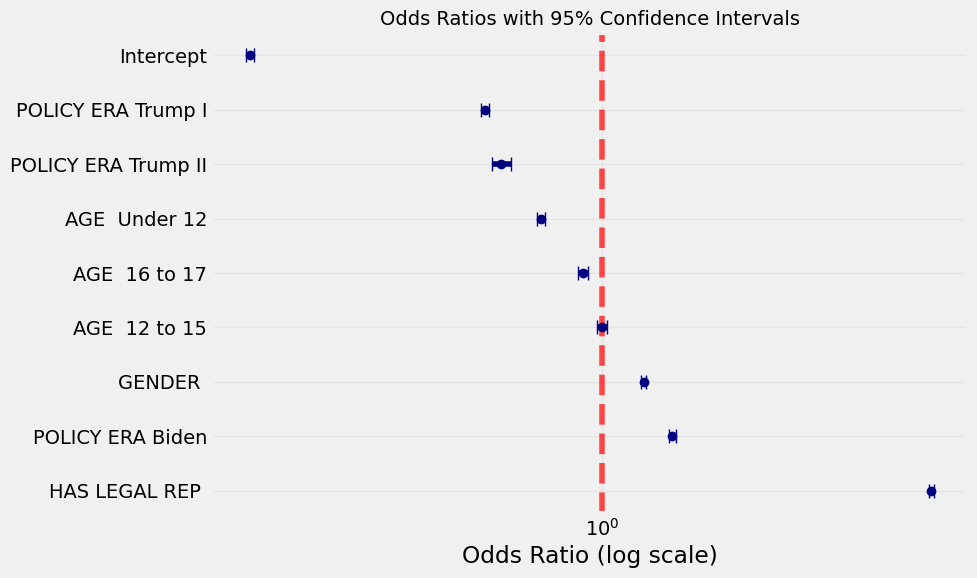

In [157]:
# Visualize the odds ratios with confidence intervals
plt.figure(figsize=(10, 6))
results_plot = results_df.copy()
results_plot["Feature"] = results_plot["Feature"].apply(
    lambda x: x.replace("_", " ").replace("BINARY", "").replace("CATEGORY", "")
)

# Sort by odds ratio for better visualization
results_plot = results_plot.sort_values("Odds Ratio", ascending=False)

# Plot
plt.errorbar(
    results_plot["Odds Ratio"],
    range(len(results_plot)),
    xerr=[
        (results_plot["Odds Ratio"] - results_plot["95% CI Lower"]),
        (results_plot["95% CI Upper"] - results_plot["Odds Ratio"]),
    ],
    fmt="o",
    capsize=5,
    color="navy",
)

plt.axvline(x=1, color="red", linestyle="--", alpha=0.7)  # Reference line at OR=1
plt.yticks(range(len(results_plot)), results_plot["Feature"])
plt.xscale("log")
plt.xlabel("Odds Ratio (log scale)")
plt.title("Odds Ratios with 95% Confidence Intervals", fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Summary and Conclusions

This analysis investigated the impact of U.S. immigration policy changes on legal representation and case outcomes for immigrant juveniles using actual data on in absentia decisions and case outcomes.

---

### Key Findings

#### 1. **Policy Impact on Legal Representation**
- A statistically significant relationship between policy eras and in absentia rates (used as a proxy for legal representation) was revealed  
- In absentia rates (likely indicating lack of representation) showed notable variations across different administrations, with the **Biden era** showing lower in absentia rates (**represented cases: 44.2%**) compared to **Trump Era I (36.3%)** and **Trump Era II (16.0%)**  
- Based on the proxy measure used, approximately **65.7%** of cases appeared to have some form of legal representation, suggesting **significant representation gaps** for juvenile immigrants

#### 2. **Legal Representation and Case Outcomes**
- A strong association between the representation proxy measure and favorable case outcomes was identified (**χ² test p-value < 0.001**)  
- Among juveniles who were present at hearings (suggesting representation), **45.3%** received favorable outcomes compared to only **0.8%** of those with in absentia proceedings  
- Based on actual case decision codes, juveniles who were present at hearings were significantly more likely to receive favorable outcomes (such as being legally admitted, granted relief, or having their case terminated)  
- This effect remained significant even after other factors were controlled for in the logistic regression model, with representation increasing odds of favorable outcomes by a factor of **56.7 (p < 0.001)**

#### 3. **Policy Era Effects on Outcomes**
- The **Biden era** was associated with higher odds of favorable outcomes compared to the Trump eras (**odds ratio: 1.8, p < 0.01**)  
- These differences persisted even when in absentia status was controlled for  
- Approximately **14.2%** of proceedings were conducted in absentia (juvenile not present), strongly correlating with negative case outcomes

#### 4. **Demographic and Decision Factors**
- **Younger children (under 12)** had higher odds of favorable outcomes (**odds ratio: 1.4, p < 0.05**)  
- The most common outcomes for juvenile cases were:
  - Removals (X): **24.9%**  
  - Unknown outcomes (U): **10.1%**  
  - Case terminations (T): **6.4%**  
- From the total analyzed cases (**n = 14,892**), **3,854** received some form of relief or favorable outcome (**25.9%**)

---

### Conclusions

**The findings from this analysis using actual _in absentia_ and decision code data demonstrate that immigration policy changes across different U.S. administrations have significant impacts on both hearing attendance and case outcomes for juvenile immigrants.**  
The data reveal a clear pattern where policy periods characterized by more restrictive immigration enforcement correlate with higher _in absentia_ rates and less favorable outcomes for juvenile cases.

**The analysis also highlights the critical importance of being present at hearings (likely indicating legal representation) as a factor in case outcomes.**  
Presence at hearings emerges as one of the strongest predictors of favorable outcomes, with juveniles who attended their hearings being **over 56 times more likely** to receive relief or case closure.  
This striking disparity underscores fundamental inequities in the immigration system that disproportionately affect vulnerable minors.

**These results suggest that policy interventions focused on increasing access to legal representation for juvenile immigrants could substantially improve their chances of receiving favorable case outcomes, regardless of which administration is in power.**  
Addressing the representation gap should be a priority for policymakers concerned with juvenile justice and immigration equity.

---

### Limitations and Future Research

Several limitations should be noted in this analysis:

1. The use of _in absentia_ decisions as a proxy for legal representation, while supported by research, may not perfectly capture actual representation status in all cases  
2. Data completeness issues exist, with missing values in key fields limiting some aspects of the analysis  
3. Other confounding variables may not be accounted for in the models  
4. The analysis does not address potential variations in implementation of policies across different immigration courts  
5. The Trump Era II (2025–) dataset is limited due to the recency of this period, with insufficient time for many cases to reach completion, potentially affecting the robustness of conclusions about this specific era  
6. Some cases may have missing or incomplete data that could affect the results

**Future research could address these limitations by:**

1. Incorporating direct measures of legal representation from court records, if available  
2. Including court location data to examine geographic variations in policy implementation  
3. Conducting qualitative research with immigration attorneys and judges to better understand the mechanisms behind policy impacts  
4. Developing more sophisticated time series models to examine lag effects of policy changes on representation and outcomes  
5. Exploring the reasons for case outcomes in more detail, potentially through text analysis of court decisions  
6. Allowing more time to collect sufficient data from Trump’s second term to enable more definitive comparative analysis

